<h1>Sparse Convolutional Denoising Autoencoders for Genotype Imputation <span class="tocSkip"></span></h1>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset</a></span><ul class="toc-item"><li><span><a href="#Loading-data" data-toc-modified-id="Loading-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Loading data</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Preprocessing</a></span></li></ul></li><li><span><a href="#Method" data-toc-modified-id="Method-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Method</a></span><ul class="toc-item"><li><span><a href="#Build-model" data-toc-modified-id="Build-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Build model</a></span></li><li><span><a href="#Generate-data" data-toc-modified-id="Generate-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Generate data</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Plot</a></span></li></ul></li><li><span><a href="#Save-model" data-toc-modified-id="Save-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Save model</a></span></li></ul></div>

# Introduction

This notebook is a case study of building a SCDA model by using completely convolutional layers with L1 regularization on the weigths, which achieves ~99% imputation accuracy on yeast genotype dataset.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Dropout
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import to_categorical

%matplotlib inline   
from matplotlib import pyplot as plt

/Users/jchen67/Experiment/deeplearning/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jchen67/Experiment/deeplearning/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jchen67/Experiment/deeplearning/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jchen67/Expe

In [2]:
# specify a seed for repeating the exact dataset splits
np.random.seed(seed=28213)

# Dataset

## Loading data

In [3]:
input_name = 'data/yeast_genotype_train.txt'
df_ori = pd.read_csv(input_name, sep='\t', index_col=0)
df_ori.shape

(3513, 28220)

In [4]:
df_ori.head()

,33070_chrI_33070_A_T,33147_chrI_33147_G_T,33152_chrI_33152_T_C,33200_chrI_33200_C_T,33293_chrI_33293_A_T,33328_chrI_33328_C_A,33348_chrI_33348_G_C,33403_chrI_33403_C_T,33502_chrI_33502_A_G,33548_chrI_33548_A_C,...,12048853_chrXVI_925593_G_C,12049199_chrXVI_925939_T_C,12049441_chrXVI_926181_C_T,12050613_chrXVI_927353_T_G,12051167_chrXVI_927907_A_C,12051240_chrXVI_927980_A_G,12051367_chrXVI_928107_C_T,12052782_chrXVI_929522_C_T,12052988_chrXVI_929728_A_G,12053130_chrXVI_929870_C_T
SAMID,,,,,,,,,,,,,,,,,,,,,
01_01,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
01_02,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
01_03,2,2,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1
01_04,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
01_06,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


## Preprocessing

In [5]:
# one hot encode
df_onehot = to_categorical(df_ori)
df_onehot.shape

(3513, 28220, 3)

In [6]:
# split df to train and valid
train_X, valid_X = train_test_split(df_onehot, test_size=0.2)

train_X.shape, valid_X.shape

((2810, 28220, 3), (703, 28220, 3))

# Method

## Build model

In [7]:
# hyperparameters
missing_perc = 0.1

# training
batch_size = 32
lr = 1e-3
epochs = 10

# conv1D
feature_size = train_X.shape[1]
inChannel = train_X.shape[2]
kr = 1e-4
drop_prec = 0.25

In [8]:
SCDA = Sequential()
# encoder
SCDA.add(Conv1D(32, 5, padding='same',activation='relu',kernel_regularizer=l1(kr),input_shape=(feature_size, inChannel)))
SCDA.add(MaxPooling1D(pool_size=2))
SCDA.add(Dropout(drop_prec))
          
SCDA.add(Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))) 
SCDA.add(MaxPooling1D(pool_size=2)) 
SCDA.add(Dropout(drop_prec))

# bridge
SCDA.add(Conv1D(128, 5, padding='same', activation='relu', kernel_regularizer=l1(kr)))

# decoder
SCDA.add(Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))) 
SCDA.add(UpSampling1D(2)) 
SCDA.add(Dropout(drop_prec))
          
SCDA.add(Conv1D(32, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))) 
SCDA.add(UpSampling1D(2))
SCDA.add(Dropout(drop_prec))

SCDA.add(Conv1D(inChannel, 5, activation='softmax', padding='same')) 


# compile
SCDA.compile(loss='categorical_crossentropy', 
                    optimizer='adam',
                    metrics=['accuracy'])

SCDA.summary()

W0817 16:48:05.953956 140734774412736 deprecation.py:506] From /Users/jchen67/Experiment/deeplearning/venv/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 28220, 32)         512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14110, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 14110, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14110, 64)         10304     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7055, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7055, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7055, 128)         4

## Generate data 

In [9]:
# Generates data for denoising autoencoder.
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, x_dataset, missing_perc=0.1, shuffle=True):
        self.batch_size = batch_size
        self.x = x_dataset
        self.missing_perc = missing_perc
        self.shuffle = shuffle
        # triggered once at the very beginning as well as at the end of each epoch.
        self.on_epoch_end()

    def __len__(self):
        # Denote the number of batches per epoch
        return int(np.floor(self.x.shape[0] / self.batch_size))

    def __getitem__(self, index):
        # Generates one batch of data
        indexes = self.indexes[index * self.batch_size:(
            index + 1) * self.batch_size]
        self.x_missing = self.x[indexes].copy()

        # Generates missing genotypes
        # different missing loci for each individuals
        for i in range(self.x_missing.shape[0]):
            missing_size = int(self.missing_perc * self.x_missing.shape[1])
            missing_index = np.random.randint(
                self.x_missing.shape[1], size=missing_size)
            # missing loci are encoded as [0, 0]
            self.x_missing[i, missing_index, :] = [1, 0, 0]

        return self.x_missing, self.x[indexes]

    def on_epoch_end(self):
        # Update indexes after each epoch
        self.indexes = np.arange(self.x.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [10]:
train_generator = DataGenerator(
    batch_size=batch_size, x_dataset=train_X, missing_perc=missing_perc)
valid_generator = DataGenerator(
    batch_size=batch_size, x_dataset=valid_X, missing_perc=missing_perc)

## Training

In [11]:
# early stopping call back with val_loss monitor
EarlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True)

# model checkpoint call back with val_acc monitor
ModelCheckpoint = keras.callbacks.ModelCheckpoint(
    'models/SCDA_checkpoint.{epoch:02d}-{val_acc:.4f}.h5',
    monitor='val_acc',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)

W0817 16:48:12.944079 140734774412736 callbacks.py:875] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [12]:
SCDA_train = SCDA.fit_generator(
    generator=train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    verbose=1,
#     callbacks=[EarlyStopping, ModelCheckpoint]
)

Epoch 1/10


W0817 16:48:17.266690 140734774412736 deprecation.py:323] From /Users/jchen67/Experiment/deeplearning/venv/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


87/87 [==============================] - 458s 5s/step - loss: 0.4331 - acc: 0.9444 - val_loss: 0.2263 - val_acc: 0.9992
Epoch 2/10
87/87 [==============================] - 279s 3s/step - loss: 0.1708 - acc: 0.9981 - val_loss: 0.1240 - val_acc: 0.9994
Epoch 3/10
87/87 [==============================] - 252s 3s/step - loss: 0.0994 - acc: 0.9981 - val_loss: 0.0759 - val_acc: 0.9994
Epoch 4/10
87/87 [==============================] - 250s 3s/step - loss: 0.0639 - acc: 0.9981 - val_loss: 0.0505 - val_acc: 0.9994
Epoch 5/10
87/87 [==============================] - 251s 3s/step - loss: 0.0447 - acc: 0.9982 - val_loss: 0.0361 - val_acc: 0.9995
Epoch 6/10
87/87 [==============================] - 253s 3s/step - loss: 0.0335 - acc: 0.9982 - val_loss: 0.0274 - val_acc: 0.9995
Epoch 7/10
87/87 [==============================] - 253s 3s/step - loss: 0.0266 - acc: 0.9983 - val_loss: 0.0219 - val_acc: 0.9995
Epoch 8/10
87/87 [==============================] - 249s 3s/step - loss: 0.0220 - acc: 0.9984 

## Plot

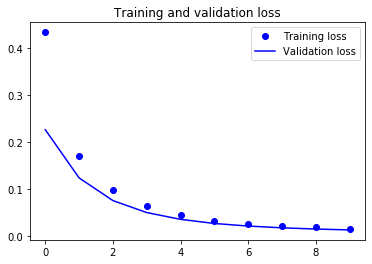

In [13]:
# plot loss curve on validation data
loss = SCDA_train.history['loss']
val_loss = SCDA_train.history['val_loss']

plt.figure()
plt.plot(range(len(loss)), loss, 'bo', label='Training loss')
plt.plot(range(len(val_loss)), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

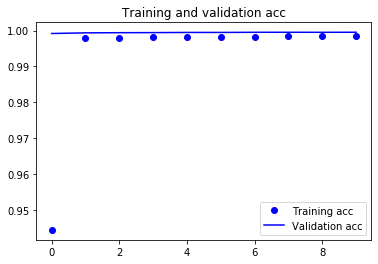

In [14]:
# plot accuracy curve on validation data
acc = SCDA_train.history['acc']
val_acc = SCDA_train.history['val_acc']
plt.figure()
plt.plot(range(len(acc)), acc, 'bo', label='Training acc')
plt.plot(range(len(val_acc)), val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.show()

# Save model

In [15]:
SCDA.save('model/SCDA.h5')  # creates a HDF5 file 'SCDA.h5'